In [80]:
import os
import sys
import cv2
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from PIL import Image
from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据

In [5]:
train, test = mnist.load_data()
train_x, train_y, test_x, test_y = train[0], train[1], test[0], test[1]

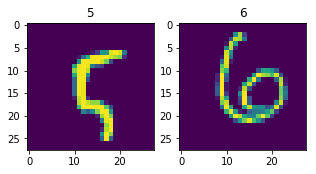

In [6]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(train_x[100])
plt.title(train_y[100])
plt.subplot(1,2,2)
plt.imshow(test_x[100])
plt.title(test_y[100])
plt.show()

# 可视化函数

In [31]:
# fork from：https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        # embeddings = np.zeros((len(dataloader), 2))
        # labels = np.zeros(len(dataloader))
        k = 0
        for i, (images, target) in enumerate(dataloader):
            images = images.to(device)
            output = model.get_embedding(images).data.cpu().numpy()
            if i == 0:
                embeddings = output
                labels = target.numpy()
            else:
                embeddings = np.vstack((embeddings, output))
                labels = np.hstack((labels, target))
            embeddings[k:k+images.shape[0]] = output
            labels[k:k+images.shape[0]] = target.numpy()
            
            k += images.shape[0]
    return embeddings, labels

# 创建Net

In [10]:
# part fork from：https://github.com/adambielski/siamese-triplet/blob/master/networks.py
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def get_embedding(self, x):
        return self.forward(x)
    
class EmbeddingNetL2(EmbeddingNet):
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(self, x):
        output = super(EmbeddingNetL2, self).forward(x)
        output /= output.pow(2).sum(1, keepdim=True).sqrt()
        return output

    def get_embedding(self, x):
        return self.forward(x)
    
    
    
class ClassifierNet(nn.Module):
    def __init__(self, categories):
        super(ClassifierNet, self).__init__()
        self.embeddingnet = EmbeddingNet()
        self.nonlinear = nn.PReLU()
        self.fc = nn.Linear(2, categories)
        
    def forward(self, x):
        x = self.embeddingnet(x)
        x = self.nonlinear(x)
        x = self.fc(x)
        return x
    
    def get_embedding(self, x):
        return self.nonlinear(self.embeddingnet(x))

# Dataloader for softmax

In [85]:
class DataGen(Dataset):
    def __init__(self, data, label, transforms=None):
        self.data = data
        self.label = label
        self.transforms = transforms
        
    def __getitem__(self, index):
        img = self.data[index]
        tag = self.label[index]
        if self.transforms:
            img = Image.fromarray(img.astype('uint8'))
            img = self.transforms(img)
        return img, tag

    def __len__(self):
        return self.data.shape[0]

In [116]:
traingen = DataGen(train_x, train_y, transforms=transforms.Compose([transforms.ToTensor()]))
trainloader = DataLoader(dataset=traingen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)
testgen = DataGen(test_x, test_y, transforms=transforms.Compose([transforms.ToTensor()]))
testloader = DataLoader(dataset=testgen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)

In [87]:
temp = iter(trainloader)
img, label = next(temp)
print(img.shape,label)

torch.Size([32, 1, 28, 28]) tensor([ 8,  6,  2,  9,  9,  4,  4,  1,  5,  8,  6,  2,  1,  7,
         3,  6,  4,  1,  4,  3,  7,  2,  9,  3,  0,  7,  1,  1,
         3,  3,  0,  2], dtype=torch.uint8)


In [11]:
model = ClassifierNet(10)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [12]:
epochs = 10

model = model.to(device)
for i in range(epochs):
    for j, (img, tag) in enumerate(trainloader):
        img = img.to(device)
        tag = tag.to(device)
        # print(tag)
        output = model(img)
        loss = criterion(output, tag.type(torch.cuda.LongTensor))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if j % 100 == 0:
            print('{}/{}, steps:{}, loss:{}'.format(i+1, epochs, j+1, loss.item()))
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for img, tag in testloader:
            img = img.to(device)
            tag = tag.to(device).type(torch.cuda.LongTensor)
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == tag).sum().item()
            total += tag.shape[0]
        print('Average Accuracy is {}'.format(correct / total))  

1/10, steps:1, loss:2.3157362937927246
1/10, steps:101, loss:1.3582979440689087
1/10, steps:201, loss:1.009324312210083
1/10, steps:301, loss:0.7351540923118591
1/10, steps:401, loss:0.609061598777771
1/10, steps:501, loss:0.42083364725112915
1/10, steps:601, loss:0.49983254075050354
1/10, steps:701, loss:0.611308217048645
1/10, steps:801, loss:0.23569631576538086
1/10, steps:901, loss:0.27480119466781616
1/10, steps:1001, loss:0.11253610253334045
1/10, steps:1101, loss:0.1295250803232193
1/10, steps:1201, loss:0.04506021738052368
1/10, steps:1301, loss:0.5298935174942017
1/10, steps:1401, loss:0.09185680001974106
1/10, steps:1501, loss:0.2397640198469162
1/10, steps:1601, loss:0.1332893818616867
1/10, steps:1701, loss:0.06380537152290344
1/10, steps:1801, loss:0.02346399426460266
Average Accuracy is 0.9777644230769231
2/10, steps:1, loss:0.04885256290435791
2/10, steps:101, loss:0.08184562623500824
2/10, steps:201, loss:0.01470184326171875
2/10, steps:301, loss:0.10408447682857513
2/1

10/10, steps:1201, loss:0.004020228981971741
10/10, steps:1301, loss:0.0013758540153503418
10/10, steps:1401, loss:0.0011112689971923828
10/10, steps:1501, loss:0.003965109586715698
10/10, steps:1601, loss:0.07080674171447754
10/10, steps:1701, loss:0.018589168787002563
10/10, steps:1801, loss:0.000330507755279541
Average Accuracy is 0.9872796474358975


# 可视化softmax结果
可视化基于分类的特征空间分布

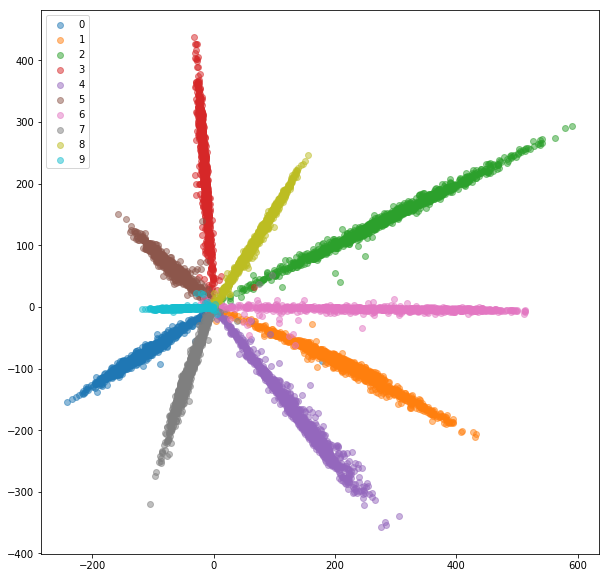

In [34]:
emebddings, labels = extract_embeddings(dataloader=testloader, model=model)
plot_embeddings(emebddings, labels)

# Dataloder for Siamese

In [88]:
'''
Siamese翻译过来是孪生，也是说两个一摸一样的模型
实际上只有一个模型，只是成对的数据通过它能够判断是否属于同一类别
所以这里需要编写孪生网络所需要的数据生成器，同类赋予label：1，异类赋予label：0
训练：
是否是同类，靠随机选取0/1值查看，
'''
import random
class SiameseDataset(Dataset):
    def __init__(self, images, labels, tag='train', transforms=None):
        self.data = images
        self.labels = labels
        self.tag = tag
        self.transforms = transforms
        self.label_set = set(labels)
        self.label2index = { i:list(np.where(labels==i)[0]) for i in self.label_set}
        
        if tag != 'train':
            '''
            依次遍历整个数据集，第i个数据，作为它的正pair，随机从所有该类别内选取一个。
            '''
            positive_pairs = [[i, 
                               random.choice(self.label2index[self.labels[i]]), 
                               1] 
                              for i in range(self.data.shape[0])]
            
            '''
            依次遍历整个数据集，第i个数据，作为它的负pair，随机从剔除该类后的其他类中随机选取一个类，然后再从选取的类中
            随机选取一个数据
            '''
            negative_pairs = [[i, 
                               random.choice(self.label2index[random.choice(list(self.label_set - set([self.labels[i]])))]), 
                               0] 
                              for i in range(self.data.shape[0])]
            
            self.test_paires = positive_pairs + negative_pairs
        
    def __getitem__(self, index):
        if self.tag == 'train':
            img1 = self.data[index]
            label = self.labels[index]
            siamese_nor = random.randint(0,1)
            if siamese_nor == 1:
                siamese_index = index
                
                while siamese_index == index:
                    siamese_index = random.choice(self.label2index[label])
            else:
                siamese_label = random.choice(list(self.label_set - set([label])))
                siamese_index = random.choice(self.label2index[siamese_label])
            img2 = self.data[siamese_index]
            label = siamese_nor
            
        else:
            sample = self.test_paires[index]
            img1 = self.data[sample[0]]
            img2 = self.data[sample[1]]
            label = sample[2]
        
        if self.transforms:
            img1 = self.transforms(Image.fromarray(img1))
            img2 = self.transforms(Image.fromarray(img2))

            
        return img1, img2, label
    
    def __len__(self):
        if self.tag == 'train':
            return len(self.data)
        else:
            return len(self.test_paires)
            
            

In [91]:
traingen = SiameseDataset(train_x, train_y, tag='train', transforms=transforms.Compose([transforms.ToTensor()]))
trainloader = DataLoader(dataset=traingen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)
testgen = SiameseDataset(test_x, test_y, tag='test', transforms=transforms.Compose([transforms.ToTensor()]))
testloader = DataLoader(dataset=testgen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)

# 检查生成器
查看下生成器是否正确

In [92]:
temp = iter(trainloader)
img1, img2, label = next(temp)
print(img1.shape,img2.shape,label)

torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28]) tensor([ 0,  1,  1,  0,  0,  1,  1,  1,  0,  0,  0,  1,  1,  0,
         0,  1,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  0,  1,
         1,  0,  0,  0])


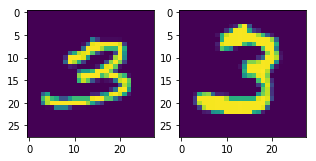

In [94]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(img1[2][0].numpy())
plt.subplot(1,2,2)
plt.imshow(img2[2][0].numpy())
plt.show()

# 对比损失
开始编写对比损失，用于训练
\begin{equation}
ContrastiveLoss = \frac{1}{2}\sum y\ast d^{2} + \frac{1}{2}\sum \left ( 1-y \right )\ast (ReLu( margin -  d))^{2}
\label{eq:ContrastiveLoss}
\end{equation}
其中d表示两个样本在空间上的欧式距离
\begin{equation}
d = \left \| embedding_{1} - embedding_{2} \right \|
\label{eq:Euclidean distance}
\end{equation}

从公式上可以看出，当y=1，也就是两个样本属于同类的时候，loss=y*d，这样迫使网络降低d的大小，当y=0，两个样本不属于同类，那么迫使d忘margin靠近，也就是距离尽量远，最终得到的结果就是类内距小（类内方差小，形成一个密集的簇），类间距趋于为margin

In [95]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, embed1, embed2, label):
        Euclid_dis = (embed1 - embed2).pow(2).sum(1)
        loss = 0.5 * (label * Euclid_dis) + 0.5 * (1 - label) * F.relu(self.margin - Euclid_dis).pow(2)
        
        return loss.mean()

In [96]:
model = EmbeddingNet()
criterion = ContrastiveLoss(margin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [98]:
epochs = 10
model = model.to(device)
for i in range(epochs):
    total_loss = 0
    for (img1, img2, tag) in tqdm(trainloader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        tag = tag.to(device).type(torch.cuda.FloatTensor)
        # print(tag)
        embedding1 = model(img1)
        embedding2 = model(img2)
        loss = criterion(embedding1, embedding2, tag)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('############## taining ##############')
    print('{}/{}, loss:{}'.format(i+1, epochs, total_loss / len(trainloader)))
    print('############## taining ##############')
    
    model.eval()
    with torch.no_grad():
        test_total_loss = 0
        for (img1, img2, tag) in tqdm(testloader):
            img1 = img1.to(device)
            img2 = img2.to(device)
            tag = tag.to(device).type(torch.cuda.FloatTensor)
            embedding1 = model(img1)
            embedding2 = model(img2)
            loss = criterion(embedding1, embedding2, tag)
            test_total_loss += loss.item()
        print('############## testing ##############')
        print('{}/{}, loss:{}'.format(i+1, epochs, test_total_loss / len(testloader)))
        print('############## testing ##############')

  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
1/10, loss:0.045292938274641835
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
1/10, loss:0.016553392502292992
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
2/10, loss:0.013336587599851192
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
2/10, loss:0.009065443953126669
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
3/10, loss:0.008518986386666075
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
3/10, loss:0.00912322435383685
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
4/10, loss:0.005924561382022997
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
4/10, loss:0.009019613889814355
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
5/10, loss:0.0038454651392957504
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
5/10, loss:0.006132525706739398
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
6/10, loss:0.004060930869150131
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
6/10, loss:0.006851168476126622
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
7/10, loss:0.003111215924359082
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
7/10, loss:0.006851974920136854
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
8/10, loss:0.002197194362373557
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
8/10, loss:0.00843005817963858
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
9/10, loss:0.002275183981853964
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
9/10, loss:0.006006137993838638
############## taining ##############


  0%|          | 0/625 [00:00<?, ?it/s]

############## taining ##############
10/10, loss:0.0019203477624085887
############## taining ##############


100%|██████████| 625/625 [00:01<00:00, 321.73it/s]

############## taining ##############
10/10, loss:0.0064664891421212815
############## taining ##############


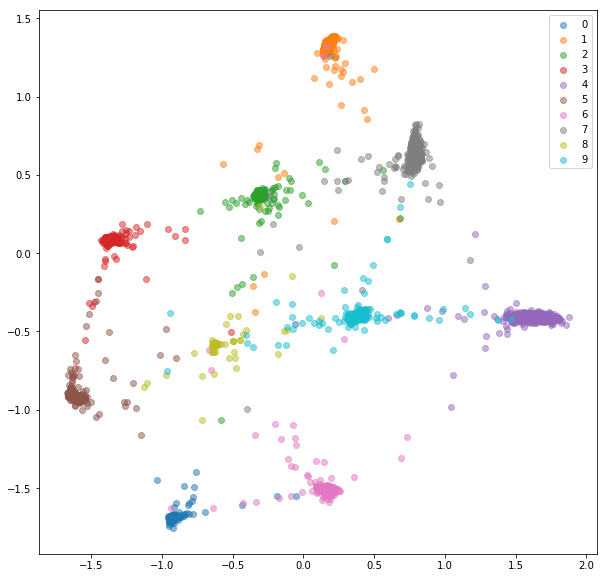

In [103]:
# 注意：这里调用下分类的生成器，因为主要是为了提取特征，孪生的生成器不适用这里
emebddings, labels = extract_embeddings(dataloader=testloader, model=model)
plot_embeddings(emebddings, labels)

# Dataloader for Triplet

In [107]:
'''
Triplet翻译过来是三元组的意思，分别表示选中样本，一个正样本，一个负样本
训练：
同类的距离越近越好，异类的距离越远越好
'''
import random
class TripletDataset(Dataset):
    def __init__(self, images, labels, tag='train', transforms=None):
        self.data = images
        self.labels = labels
        self.tag = tag
        self.transforms = transforms
        self.label_set = set(labels)
        self.label2index = { i:list(np.where(labels==i)[0]) for i in self.label_set}
        
        if tag != 'train':
            '''
            依次遍历整个数据集，第i个数据，作为它的正pair，随机从所有该类别内选取一个，负样本随机选取一个异类，再随机选取其中一个样本。
            '''
            triplets = [[i, 
                        random.choice(self.label2index[self.labels[i]]), 
                        random.choice(self.label2index[random.choice(list(self.label_set - set([self.labels[i]])))])
                        ] 
                        for i in range(self.data.shape[0])]
            

            
            self.test_triplet = triplets
        
    def __getitem__(self, index):
        if self.tag == 'train':
            img1 = self.data[index]
            label = self.labels[index]
            
            postive_index = index
            while postive_index == index:
                postive_index = random.choice(self.label2index[label])
            img2 = self.data[postive_index
                            ]
            negtive_label = random.choice(list(self.label_set - set([label])))
            negtive_index = random.choice(self.label2index[negtive_label])
            img3 = self.data[negtive_index]
            
        else:
            sample = self.test_triplet[index]
            img1 = self.data[sample[0]]
            img2 = self.data[sample[1]]
            img3 = self.data[sample[2]]
        
        if self.transforms:
            img1 = self.transforms(Image.fromarray(img1))
            img2 = self.transforms(Image.fromarray(img2))
            img3 = self.transforms(Image.fromarray(img3))

            
        return img1, img2, img3
    
    def __len__(self):
        if self.tag == 'train':
            return len(self.data)
        else:
            return len(self.test_triplet)
            
            

In [108]:
traingen = TripletDataset(train_x, train_y, tag='train', transforms=transforms.Compose([transforms.ToTensor()]))
trainloader = DataLoader(dataset=traingen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)
testgen = TripletDataset(test_x, test_y, tag='test', transforms=transforms.Compose([transforms.ToTensor()]))
testloader = DataLoader(dataset=testgen,
                         batch_size=32,
                         pin_memory=False,
                         drop_last=True,
                         shuffle=True,
                         num_workers=10)

In [109]:
temp = iter(trainloader)
img1, img2, img3 = next(temp)
print(img1.shape, img2.shape, img3.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])


# TripletLoss
开始编写triplet loss  

\begin{equation}
TripletLoss = max(0, \left \| embedding_{anchor} - embedding_{postive} \right \|+ margin - \left \| embedding_{anchor} - embedding_{negtive} \right \|)
\label{eq:TripletLoss}
\end{equation}  

该损失有三个输入，第一个anchor为锚点，postive为它的正样本，negtive为它的负样本，这个损失的思想就是锚点与负样本的距离相比与正样本的距离，始终都要大于/等于margin，它只在乎类间距，类内距不关心，

In [113]:
class TripleLoss(nn.Module):
    def __init__(self, margin):
        super(TripleLoss, self).__init__()
        self.margin = margin
        
    def forward(self, a, p, n):
        ap = (a - p).pow(2).sum(1).sqrt()
        an = (a - n).pow(2).sum(1).sqrt()
        loss = F.relu(self.margin + ap - an)
        return loss.mean()

In [114]:
model = EmbeddingNet()
criterion = TripleLoss(margin=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [115]:
epochs = 10
model = model.to(device)
for i in range(epochs):
    total_loss = 0
    for (img1, img2, img3) in tqdm(trainloader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        img3 = img3.to(device)
        # print(tag)
        a = model(img1)
        p = model(img2)
        n = model(img3)
        loss = criterion(a, p, n)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('############## taining ##############')
    print('{}/{}, loss:{}'.format(i+1, epochs, total_loss / len(trainloader)))
    print('############## taining ##############')
    
    model.eval()
    with torch.no_grad():
        test_total_loss = 0
        for (img1, img2, img3) in tqdm(trainloader):
            img1 = img1.to(device)
            img2 = img2.to(device)
            img3 = img3.to(device)
            # print(tag)
            a = model(img1)
            p = model(img2)
            n = model(img3)
            loss = criterion(a, p, n)
            test_total_loss += loss.item()
        print('############## testing ##############')
        print('{}/{}, loss:{}'.format(i+1, epochs, test_total_loss / len(testloader)))
        print('############## testing ##############')

  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
1/10, loss:0.12208410532176495
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
1/10, loss:0.27905179804955155
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
2/10, loss:0.03900443653166294
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
2/10, loss:0.17890407632773694
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
3/10, loss:0.02682849454085032
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
3/10, loss:0.13524155137248528
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
4/10, loss:0.023869294673204422
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
4/10, loss:0.1075572249216911
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
5/10, loss:0.020457658395171167
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
5/10, loss:0.09015880267804441
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
6/10, loss:0.017754235817988715
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
6/10, loss:0.08647458577074875
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
7/10, loss:0.014819378702839215
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
7/10, loss:0.07458421202877966
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
8/10, loss:0.014051917548974354
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
8/10, loss:0.06982268569155191
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
9/10, loss:0.012636105716228484
############## taining ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## testing ##############
9/10, loss:0.10538623517809007
############## testing ##############


  0%|          | 0/1875 [00:00<?, ?it/s]

############## taining ##############
10/10, loss:0.01255327506562074
############## taining ##############


100%|██████████| 1875/1875 [00:05<00:00, 325.33it/s]

############## testing ##############
10/10, loss:0.0712611548578701
############## testing ##############


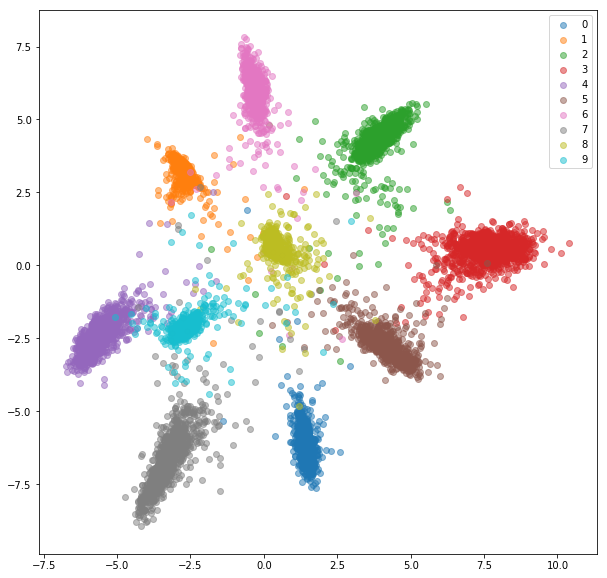

In [117]:
embeddings, labels = extract_embeddings(testloader, model)
plot_embeddings(embeddings, labels)